# Imbalanced classes experiment
## January 10th, 2017
### Dr Jose M Albornoz

An experiment to determine a good class imbalance compensation strategy. Two strategies are being compared here: a) do nothing; b) set class weights in the estimators (random forests & logistic regression)

# Import necessary modules

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

import numpy as np
import seaborn as sbs
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.utils import resample
from sklearn.learning_curve import validation_curve
from sklearn.model_selection import train_test_split

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.classifier import StackingClassifier

import seaborn as sns
import timeit

RANDOM_STATE = 19

# 1 Load data

In [4]:
wine_df_white = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', 
                      sep=';')

In [5]:
wine_df_red = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', 
                      sep=';')

In [6]:
wine_df = pd.concat([wine_df_white, wine_df_red])

In [7]:
# shuffle data set
wine_df = wine_df.sample(frac=1, random_state=RANDOM_STATE)
wine_df = wine_df.sample(frac=1, random_state=RANDOM_STATE)
wine_df = wine_df.sample(frac=1, random_state=RANDOM_STATE)

In [8]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1699,6.3,0.26,0.29,2.2,0.043,35.0,175.0,0.99180,3.38,0.43,11.6,6
4431,6.6,0.38,0.28,2.8,0.043,17.0,67.0,0.98924,3.21,0.47,13.2,6
13,7.8,0.61,0.29,1.6,0.114,9.0,29.0,0.99740,3.26,1.56,9.1,5
1065,7.7,0.61,0.18,2.4,0.083,6.0,20.0,0.99630,3.29,0.60,10.2,6
134,7.9,1.04,0.05,2.2,0.084,13.0,29.0,0.99590,3.22,0.55,9.9,6


In [9]:
wine_df.shape

(6497, 12)

In [10]:
wine_df['quality'].unique()

array([6, 5, 4, 7, 8, 3, 9])

# 2 Create unbalanced target variable

In [11]:
def f(row):
    if row['quality'] < 7:
        val = 0
    else:
        val = 1
    return val

In [12]:
wine_df['score'] = wine_df.apply(f, axis=1)

In [13]:
np.bincount(wine_df['score'])

array([5220, 1277])

In [15]:
np.bincount(wine_df['score'])*100/len(wine_df)

array([80, 19])

# 3 Training and tests sets: raw dataset

In [16]:
df_train_raw, df_test_raw = train_test_split(wine_df, test_size=0.2)

In [17]:
df_train_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,score
243,15.0,0.210,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,1
464,11.5,0.315,0.54,2.1,0.084,5.0,15.0,0.99870,2.98,0.70,9.2,6,0
557,15.6,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5,0
1388,7.3,0.180,0.29,1.2,0.044,12.0,143.0,0.99180,3.20,0.48,11.3,7,1
992,6.5,0.250,0.27,15.2,0.049,75.0,217.0,0.99720,3.19,0.39,9.9,5,0


In [18]:
df_train_raw.shape

(5197, 13)

In [19]:
df_test_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,score
2066,7.7,0.28,0.29,4.3,0.051,25.0,142.0,0.99390,3.16,0.39,10.2,5,0
1909,7.6,0.13,0.34,9.3,0.062,40.0,126.0,0.99660,3.21,0.39,9.6,5,0
1924,7.6,0.26,0.36,1.6,0.032,6.0,106.0,0.99300,3.15,0.40,10.4,4,0
1010,8.9,0.28,0.45,1.7,0.067,7.0,12.0,0.99354,3.25,0.55,12.3,7,1
1243,7.1,0.44,0.37,2.7,0.041,35.0,128.0,0.98960,3.07,0.43,13.5,7,1


In [20]:
df_test_raw.shape

(1300, 13)

## 3.1 Training set

In [21]:
y_train1 = df_train_raw['score'].values

In [22]:
X_train1 = df_train_raw.drop(['score'], axis=1).values

In [23]:
X_train1.shape

(5197, 12)

## 3.2 Test set

In [24]:
y_test1 = df_test_raw['score'].values

In [25]:
df_test1 = df_test_raw.drop(['score'], axis = 1)

In [26]:
X_test1 = df_test_raw.drop(['score'], axis=1).values

In [27]:
X_test1.shape

(1300, 12)

# 4 Data normalisation

In [28]:
scl = StandardScaler()    

## 4.1 Normalisation - raw dataset

In [29]:
scl.fit(X_train1)
X_train1_norm = scl.transform(X_train1)
X_test1_norm = scl.transform(X_test1)

# 5 Model Definition

## 5.1 Estimator definition

In [30]:
clf11 = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1) 

In [31]:
clf12 = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight={1:4}) 

In [32]:
clf21 = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [33]:
clf22 = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight={1:4})

## 5.2 Search space definition

In [34]:
param_grid1 = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 
               'max_features': ['auto', 'sqrt', 'log2']}

In [35]:
param_grid2 = {'criterion': ['gini', 'entropy'], 'min_samples_split' : range(10,500,20), 'max_depth': range(1,20,2)} 

## 5.3 Grid search definition

In [36]:
gs11 = GridSearchCV(estimator=clf11, param_grid=param_grid1, scoring='roc_auc', cv=10, n_jobs=-1)

In [37]:
gs12 = GridSearchCV(estimator=clf12, param_grid=param_grid1, scoring='roc_auc', cv=10, n_jobs=-1)

In [38]:
gs21 = GridSearchCV(estimator=clf21, param_grid=param_grid2, scoring='roc_auc', cv=10, n_jobs=-1)

In [39]:
gs22 = GridSearchCV(estimator=clf22, param_grid=param_grid2, scoring='roc_auc', cv=10, n_jobs=-1)

# 6 Model selection, raw dataset

## 6.1 Grid search

In [40]:
start_time = timeit.default_timer()
gs11 = gs11.fit(X_train1_norm, y_train1)
elapsed = (timeit.default_timer() - start_time)/60
print('Execution time is {}'.format(elapsed))

Execution time is 37.1201662978


In [41]:
start_time = timeit.default_timer()
gs21 = gs12.fit(X_train1_norm, y_train1)
elapsed = (timeit.default_timer() - start_time)/60
print('Execution time is {}'.format(elapsed))

Execution time is 2.54883265098


In [42]:
start_time = timeit.default_timer()
gs21 = gs21.fit(X_train1_norm, y_train1)
elapsed = (timeit.default_timer() - start_time)/60
print('Execution time is {}'.format(elapsed))

Execution time is 2.38642493089


In [43]:
start_time = timeit.default_timer()
gs22 = gs22.fit(X_train1_norm, y_train1)
elapsed = (timeit.default_timer() - start_time)/60
print('Execution time is {}'.format(elapsed))

Execution time is 0.157109435399


In [44]:
gs11.best_score_

1.0

In [45]:
gs12.best_score_

1.0

In [46]:
gs21.best_score_

1.0

In [47]:
gs22.best_score_

1.0

In [48]:
gs11.best_params_

{'max_features': 'auto', 'n_estimators': 50}

In [49]:
gs12.best_params_

{'max_features': 'auto', 'n_estimators': 50}

In [50]:
gs21.best_params_

{'max_features': 'auto', 'n_estimators': 50}

In [51]:
gs22.best_params_

{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10}

## 6.2 Best estimators

In [52]:
clf11_b = gs11.best_estimator_

In [53]:
clf12_b = gs12.best_estimator_

In [54]:
clf21_b = gs21.best_estimator_

In [55]:
clf22_b = gs22.best_estimator_

## 6.3 Performance on test set

In [56]:
y_pred11 = clf11_b.predict(X_test1_norm)

In [57]:
y_pred12 = clf12_b.predict(X_test1_norm)

In [58]:
y_pred21 = clf21_b.predict(X_test1_norm)

In [59]:
y_pred22 = clf22_b.predict(X_test1_norm)

In [60]:
roc_auc_score(y_test1, y_pred11)

1.0

In [61]:
roc_auc_score(y_test1, y_pred12)

1.0

In [62]:
roc_auc_score(y_test1, y_pred21)

1.0

In [63]:
roc_auc_score(y_test1, y_pred22)

1.0

## 6.4 Confusion Matrix

In [64]:
np.bincount(y_test1)

array([1072,  228])

In [65]:
confusion11 = confusion_matrix(y_test1, y_pred11)
confusion11

array([[1072,    0],
       [   0,  228]])

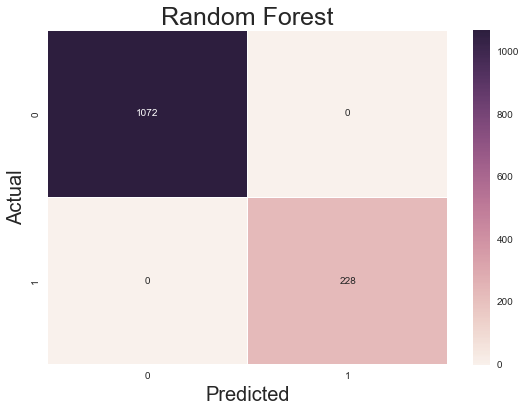

In [66]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion11, annot=True, fmt="d", linewidths=.5)
sns.plt.xlabel('Predicted', fontsize=20)
sns.plt.ylabel('Actual', fontsize=20)
sns.plt.title('Random Forest', fontsize = 25)

In [67]:
confusion12 = confusion_matrix(y_test1, y_pred12)
confusion12

array([[1072,    0],
       [   0,  228]])

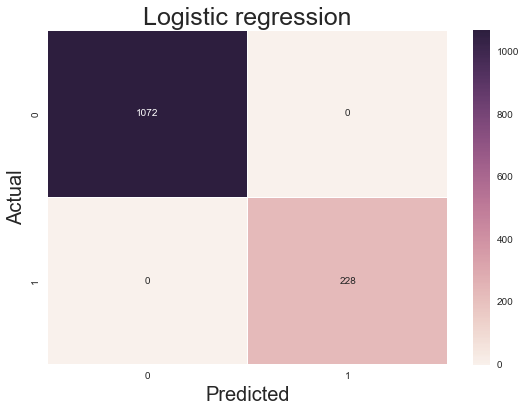

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion12, annot=True, fmt="d", linewidths=.5)
sns.plt.xlabel('Predicted', fontsize=20)
sns.plt.ylabel('Actual', fontsize=20)
sns.plt.title('Logistic regression', fontsize = 25)

In [69]:
confusion21 = confusion_matrix(y_test1, y_pred21)
confusion21

array([[1072,    0],
       [   0,  228]])

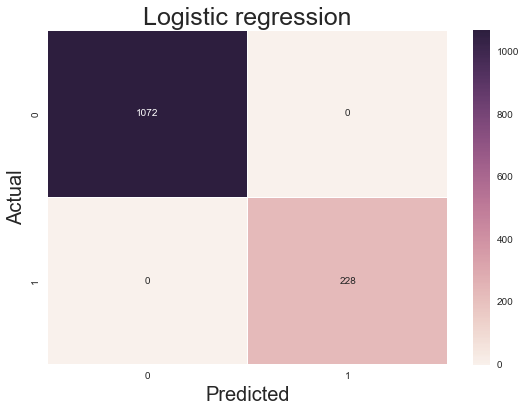

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion21, annot=True, fmt="d", linewidths=.5)
sns.plt.xlabel('Predicted', fontsize=20)
sns.plt.ylabel('Actual', fontsize=20)
sns.plt.title('Logistic regression', fontsize = 25)

In [71]:
confusion22 = confusion_matrix(y_test1, y_pred22)
confusion22

array([[1072,    0],
       [   0,  228]])

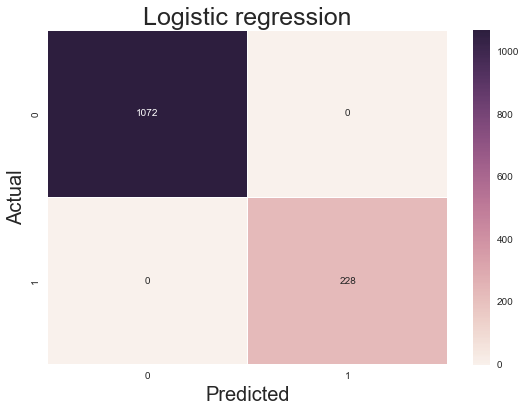

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion22, annot=True, fmt="d", linewidths=.5)
sns.plt.xlabel('Predicted', fontsize=20)
sns.plt.ylabel('Actual', fontsize=20)
sns.plt.title('Logistic regression', fontsize = 25)

## 6.5 Accuracy

In [73]:
# Overall, how often is the classifier correct?
# random forest
accuracy_score(y_test1, y_pred11)

1.0

In [74]:
# Overall, how often is the classifier correct?
# random forest
accuracy_score(y_test1, y_pred12)

1.0

In [75]:
# Overall, how often is the classifier correct?
# logistic regression
accuracy_score(y_test1, y_pred21)

1.0

In [76]:
# Overall, how often is the classifier correct?
# logistic regression
accuracy_score(y_test1, y_pred22)

1.0

## 6.6 Classification error

In [77]:
# Overall, how often is the classifier incorrect?
# random forest
1 - accuracy_score(y_test1, y_pred11)

0.0

In [78]:
# Overall, how often is the classifier incorrect?
# random forest
1 - accuracy_score(y_test1, y_pred12)

0.0

In [79]:
# Overall, how often is the classifier incorrect?
# logistic regression
1 - accuracy_score(y_test1, y_pred21)

0.0

In [80]:
# Overall, how often is the classifier incorrect?
# logistic regression
1 - accuracy_score(y_test1, y_pred22)

0.0

## 6.7 Recall

In [81]:
# When the actual value is positive, how often is the prediction correct?
# random forest
recall_score(y_test1, y_pred11)

1.0

In [82]:
# When the actual value is positive, how often is the prediction correct?
# random forest
recall_score(y_test1, y_pred12)

1.0

In [83]:
# When the actual value is positive, how often is the prediction correct?
# logistic regression
recall_score(y_test1, y_pred21)

1.0

In [84]:
# When the actual value is positive, how often is the prediction correct?
# logistic regression
recall_score(y_test1, y_pred22)

1.0

## 6.8 Precision

In [85]:
# When a positive value is predicted, how often is the prediction correct?
# random forest
precision_score(y_test1, y_pred11)

1.0

In [86]:
# When a positive value is predicted, how often is the prediction correct?
# random forest
precision_score(y_test1, y_pred12)

1.0

In [87]:
# When a positive value is predicted, how often is the prediction correct?
# logistic regression
precision_score(y_test1, y_pred21)

1.0

In [88]:
# When a positive value is predicted, how often is the prediction correct?
# logistic regression
precision_score(y_test1, y_pred22)

1.0